In [1]:
%%sh

workdir="./gfg"
password="de6460c95e1b155e3c6b7123f987404cd0b1c739c33ba702825ab8b5c6db5a10"
zip_url="https://github.com/GFG/gfg-data-engineer-challenges/raw/refs/heads/master/data/sample-data/test_data.zip"
output_zip="test_data.zip"
extract_folder="raw"

mkdir "$workdir"

echo -n "$raw_password" | sha256sum | awk '{print $1}'

cd "$workdir" && \
    curl -L "$zip_url" -o "$output_zip" && \
    mkdir -p "$extract_folder" && \
    unzip -P "$password" "$output_zip" -d "$extract_folder"


e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855
Archive:  test_data.zip
  inflating: raw/data.json           


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3398k  100 3398k    0     0  4010k      0 --:--:-- --:--:-- --:--:-- 4010k


In [126]:
%%sh
mkdir ./jars

curl -o ./jars/postgresql-42.7.3.jar https://repo1.maven.org/maven2/org/postgresql/postgresql/42.7.3/postgresql-42.7.3.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1063k  100 1063k    0     0  5714k      0 --:--:-- --:--:-- --:--:-- 5719k


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = (SparkSession
    .Builder()
    .config("spark.jars", "/jars/postgresql-42.7.3.jar")
    .getOrCreate()
)

# **Stage 1:** Clean

In [29]:
import numpy as np

def non_null_stats(df: DataFrame) -> DataFrame:
    total_rows = df.count()

    agg_exprs = [count(c).alias(c) for c in df.columns]

    counts_row = df.agg(*agg_exprs).collect()[0].asDict()

    result = []
    for col_name in df.columns:
        cnt = counts_row[col_name]
        pct = np.round(cnt / total_rows * 100, 2).item() if total_rows else 0.0
        result.append((col_name, cnt, pct))

    return spark.createDataFrame(result,
                                 schema=["column", "non_null_count", "non_null_percent"])

In [4]:
# 46279 -> 46030 unique, duplicated on rows based on customer_id
rawDf = (spark
    .read
    .json("./gfg/raw/data.json")
)

In [30]:
# NULL values in `coupon_discount_applied`
non_null_stats(rawDf).show(50, False)

+------------------------+--------------+----------------+
|column                  |non_null_count|non_null_percent|
+------------------------+--------------+----------------+
|afterpay_payments       |46279         |100.0           |
|android_orders          |46279         |100.0           |
|apple_payments          |46279         |100.0           |
|average_discount_onoffer|46279         |100.0           |
|average_discount_used   |46279         |100.0           |
|cancels                 |46279         |100.0           |
|cc_payments             |46279         |100.0           |
|coupon_discount_applied |36074         |77.95           |
|curvy_items             |46279         |100.0           |
|customer_id             |46279         |100.0           |
|days_since_first_order  |46279         |100.0           |
|days_since_last_order   |46279         |100.0           |
|desktop_orders          |46279         |100.0           |
|devices                 |46279         |100.0          

In [37]:
# Duplicated in `customer_id`, this is snapshot of a customer behavior -> should not be duplicated
(
    rawDf
    .groupBy("customer_id")
    .count()
    .orderBy(desc("count"))
    .show(10, False)
)

+--------------------------------+-----+
|customer_id                     |count|
+--------------------------------+-----+
|42753fe23766ec59f9deeac24fa2b37c|2    |
|41ae01228cfaddc6a390ccdd8be05a66|2    |
|be480b8b55bde46111bfebe458e1b85e|2    |
|9190e94817c4509c3cbcb09a8b1e9677|2    |
|76a6a8ee5a2f768316071a1342d44e50|2    |
|20b429d6036995dfe30b108c5e1f0026|2    |
|87d7e5d6d3855d26242edecaae0e64d7|2    |
|f1b81544e10b9ed99b5143d93159914f|2    |
|d4abaacf27a894451ad754615b092ec0|2    |
|7cd0a8a06ce7b3f1b87e4c740641dce3|2    |
+--------------------------------+-----+
only showing top 10 rows



In [5]:
customer_activity_cols = [
    "days_since_first_order", "days_since_last_order",
    "orders", "items", "cancels", "returns"
]

address_shipping_cols = [
    "different_addresses", "shipping_addresses",
    "work_orders", "home_orders", "parcelpoint_orders",
    "other_collection_orders"
]

payment_cols = [
    "cc_payments", "paypal_payments",
    "afterpay_payments", "apple_payments"
]

device_channel_cols = [
    "devices",
    "msite_orders", "desktop_orders",
    "android_orders", "ios_orders", "other_device_orders"
]

product_cols = [
    "female_items", "male_items", "unisex_items",
    "wapp_items", "wftw_items", "mapp_items",
    "wacc_items", "macc_items", "mftw_items",
    "wspt_items", "mspt_items", "curvy_items", "sacc_items"
]

discount_rev_cols = [
    "average_discount_onoffer", "average_discount_used", "revenue"
]


engagement_cols = [
    "is_newsletter_subscriber", "vouchers",
    "coupon_discount_applied", "redpen_discount_used"
]

## `days_since_last_order`, wrong counting unit

<ipython-input-6-11980858>:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([day_since_order_pdf[c] for c in day_since_order_cols], labels=day_since_order_cols)


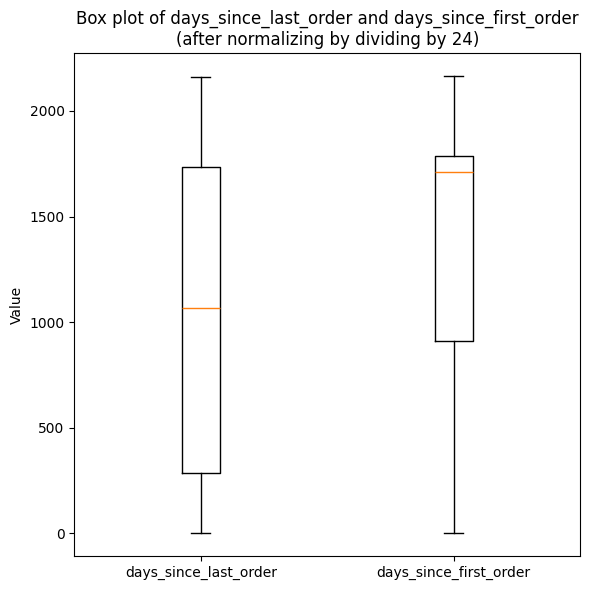

In [6]:
day_since_order_cols = ["days_since_last_order", "days_since_first_order"]

day_since_order_pdf = (
    rawDf
    .select(*day_since_order_cols)
    .withColumn("days_since_last_order", (col("days_since_last_order") / 24.0).cast(IntegerType()))
    .toPandas()
)

fig, ax = plt.subplots(figsize=(6, 6))
ax.boxplot([day_since_order_pdf[c] for c in day_since_order_cols], labels=day_since_order_cols)
ax.set_ylabel("Value")
ax.set_title("Box plot of " + " and ".join(day_since_order_cols) + "\n(after normalizing by dividing by 24)")
plt.tight_layout()
plt.show()

`days_since_last_order` has outliers, up to 52.000 days (≈ 142 years)
-> Figure out a mistake in time unit, `days_since_last_order` was in hour not in day unit

| **Before** | **After** |
|:----------:|:---------:|
|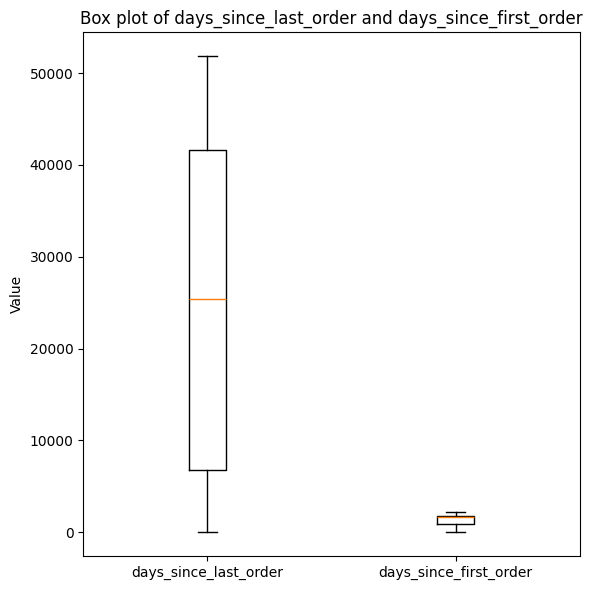|           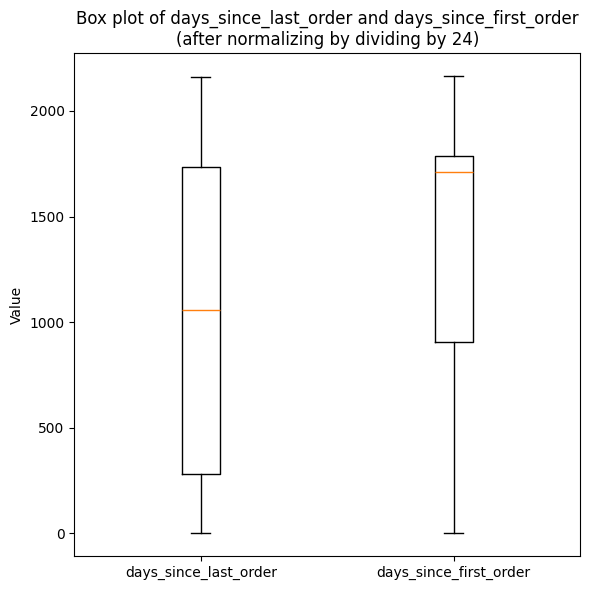|



In [38]:
finalDf = ( rawDf
    # Fill NULL value of `coupon_discount_applied` with 0.0
    .withColumn("coupon_discount_applied", when(col("coupon_discount_applied").isNull(), lit(0.0)).otherwise(col("coupon_discount_applied")))

    # Normalize `days` by dividing by 24
    .withColumn("days_since_last_order", (col("days_since_last_order") / 24.0).cast(IntegerType()))

    # Values are just Y/N only, normalize `flag` by validating yes -> true, no -> false
    .withColumn("is_newsletter_subscriber",
        when(upper("is_newsletter_subscriber") == "Y", True)
        .otherwise(False).cast(BooleanType())
    )

    # Some duplicated records
    .dropDuplicates()
)

In [39]:
(
    finalDf
    .write
    .parquet("./gfg/preprocessed/20250616-Customer-Snapshot")
)